## Comparing Demand ##

we have two demand datasets:

1. Obs data from ERA5 conversion
2. Model data (first NDJFMAMJJASO) from HadGEM3-GC31-MM conversion

We want to compare the model demand data to the obs demand data to see how similar/different these are and visually assess whether we are getting similar(-ish) values. 

In [1]:
# cell magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load local modules
import os
import sys
import glob
import importlib

# Import external modules
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# tqdm for progress bars
from tqdm import tqdm

In [2]:
# Set up the global variables
dfs_dir = "/gws/nopw/j04/canari/users/benhutch/met_to_energy_dfs"

# model filename
model_demand_fname = "wd_demand_United_Kingdom_month11-10_init1960-2018.csv"

# obs filename
obs_demand_fname = "obs_wd_demand_1960_2019_United_Kingdom.csv"

In [3]:
# load the model data
model_demand = pd.read_csv(os.path.join(dfs_dir, model_demand_fname))

# load the obs data
obs_demand = pd.read_csv(os.path.join(dfs_dir, obs_demand_fname))

In [4]:
model_demand.head()

,init,member,lead,United_Kingdom_tas,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
0,1960,r7i1p1f2,1,8.942216,6.557784,0.0,39.958743
1,1960,r7i1p1f2,2,7.611440,7.888560,0.0,40.953643
2,1960,r7i1p1f2,3,8.075678,7.424322,0.0,40.606574
3,1960,r7i1p1f2,4,7.372388,8.127612,0.0,41.132360
4,1960,r7i1p1f2,5,6.361683,9.138317,0.0,41.887972


In [5]:
obs_demand.head()

,Unnamed: 0,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
0,1960-11-01,9.970184,5.529816,0.0,39.190225
1,1960-11-02,8.484436,7.015564,0.0,40.300983
2,1960-11-03,6.850250,8.649750,0.0,41.522715
3,1960-11-04,7.034576,8.465424,0.0,41.384911
4,1960-11-05,7.439514,8.060486,0.0,41.082176


### Processing data ###

For comparison, we want to quantify the winter (NDJFM) mean demand for both the model data and the obs data.

For the model data, this will be the average of the first 30*5=150 leads for each init year and member.

For the obs data, this will be the average NDJFM for each year - e.g. for 1960 this will be the mean of Nov. 1 1960 - April 1 1961.

In [6]:
# Process the observed data
# Convert "Unnamed: 0" to datetime format
obs_demand["Unnamed: 0"] = pd.to_datetime(obs_demand["Unnamed: 0"])

# Set the "Unnamed: 0" column as the index
obs_demand.set_index("Unnamed: 0", inplace=True)

# remove the name of the index
obs_demand.index.name = None

# constrain to NDJFM
obs_demand_NDJFM = obs_demand.loc[obs_demand.index.month.isin([11, 12, 1, 2, 3])]

# Shift back by 3 months and take the annual mean
obs_demand_NDJFM = obs_demand_NDJFM.shift(-3).resample("A").mean()

In [7]:
# reformat the index to just have years
obs_demand_NDJFM.index = obs_demand_NDJFM.index.year

In [8]:
obs_demand_NDJFM.head()

,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
1960,4.710311,10.789689,0.0,43.122552
1961,4.666789,10.833211,0.0,43.155090
1962,3.104475,12.395525,0.0,44.323089
1963,1.975372,13.524628,0.0,45.167216
1964,3.774322,11.725678,0.0,43.822306


In [9]:
model_demand.head()

,init,member,lead,United_Kingdom_tas,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
0,1960,r7i1p1f2,1,8.942216,6.557784,0.0,39.958743
1,1960,r7i1p1f2,2,7.611440,7.888560,0.0,40.953643
2,1960,r7i1p1f2,3,8.075678,7.424322,0.0,40.606574
3,1960,r7i1p1f2,4,7.372388,8.127612,0.0,41.132360
4,1960,r7i1p1f2,5,6.361683,9.138317,0.0,41.887972


In [10]:
# Process the model data
# Set up an empty dataframe to store the model data
model_demand_NDJFM = pd.DataFrame()

# loop over the unique inits in the model data
for init in model_demand["init"].unique():
    # constrain to the current init
    model_demand_init = model_demand.loc[model_demand["init"] == init]
    # loop over the unique members in the model data
    for member in model_demand_init["member"].unique():
        # constrain to the current member
        model_demand_member = model_demand_init.loc[model_demand_init["member"] == member]

        # Take the mean over leads 1-150
        model_demand_member_mean = model_demand_member[model_demand_member["lead"].isin(range(1, 151))].groupby(["init", "member"]).mean()

        # add the mean to the model_demand_NDJFM dataframe
        model_demand_NDJFM = pd.concat([model_demand_NDJFM, model_demand_member_mean])


In [11]:
model_demand_NDJFM.head()

lead  United_Kingdom_tas  United_Kingdom_hdd  \
init member                                                   
1960 r7i1p1f2  75.5            4.428282           11.071718   
     r1i1p1f2  75.5            5.206377           10.293623   
     r6i1p1f2  75.5            3.158589           12.341411   
     r2i1p1f2  75.5            4.630105           10.869895   
     r4i1p1f2  75.5            5.200538           10.299462   

               United_Kingdom_cdd  United_Kingdom_demand  
init member                                               
1960 r7i1p1f2                 0.0              43.333399  
     r1i1p1f2                 0.0              42.751689  
     r6i1p1f2                 0.0              44.282633  
     r2i1p1f2                 0.0              43.182515  
     r4i1p1f2                 0.0              42.756054

In [12]:
rows_with_init_1960 = model_demand_NDJFM.loc[1960]
print(rows_with_init_1960)

           lead  United_Kingdom_tas  United_Kingdom_hdd  United_Kingdom_cdd  \
member                                                                        
r7i1p1f2   75.5            4.428282           11.071718                 0.0   
r1i1p1f2   75.5            5.206377           10.293623                 0.0   
r6i1p1f2   75.5            3.158589           12.341411                 0.0   
r2i1p1f2   75.5            4.630105           10.869895                 0.0   
r4i1p1f2   75.5            5.200538           10.299462                 0.0   
r9i1p1f2   75.5            5.623064            9.876936                 0.0   
r10i1p1f2  75.5            4.941766           10.558234                 0.0   
r3i1p1f2   75.5            4.810368           10.689632                 0.0   
r5i1p1f2   75.5            5.778914            9.721086                 0.0   
r8i1p1f2   75.5            4.661030           10.838970                 0.0   

           United_Kingdom_demand  
member          

In [13]:
# set member as its own column
model_demand_NDJFM.reset_index(inplace=True)

In [14]:
model_demand_NDJFM.head()

,init,member,lead,United_Kingdom_tas,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
0,1960,r7i1p1f2,75.5,4.428282,11.071718,0.0,43.333399
1,1960,r1i1p1f2,75.5,5.206377,10.293623,0.0,42.751689
2,1960,r6i1p1f2,75.5,3.158589,12.341411,0.0,44.282633
3,1960,r2i1p1f2,75.5,4.630105,10.869895,0.0,43.182515
4,1960,r4i1p1f2,75.5,5.200538,10.299462,0.0,42.756054


In [15]:
# Convert init to datetime format
model_demand_NDJFM.index = pd.to_datetime(model_demand_NDJFM["init"], format="%Y")

# Set the "init" column as the index
model_demand_NDJFM.set_index("init", inplace=True)

# remove the name of the index
model_demand_NDJFM.index.name = None

In [16]:
# remove the lead column
model_demand_NDJFM.drop(columns="lead", inplace=True)

In [17]:
model_demand_NDJFM.head()

,member,United_Kingdom_tas,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
1960,r7i1p1f2,4.428282,11.071718,0.0,43.333399
1960,r1i1p1f2,5.206377,10.293623,0.0,42.751689
1960,r6i1p1f2,3.158589,12.341411,0.0,44.282633
1960,r2i1p1f2,4.630105,10.869895,0.0,43.182515
1960,r4i1p1f2,5.200538,10.299462,0.0,42.756054


In [18]:
obs_demand_NDJFM.head()

,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
1960,4.710311,10.789689,0.0,43.122552
1961,4.666789,10.833211,0.0,43.155090
1962,3.104475,12.395525,0.0,44.323089
1963,1.975372,13.524628,0.0,45.167216
1964,3.774322,11.725678,0.0,43.822306


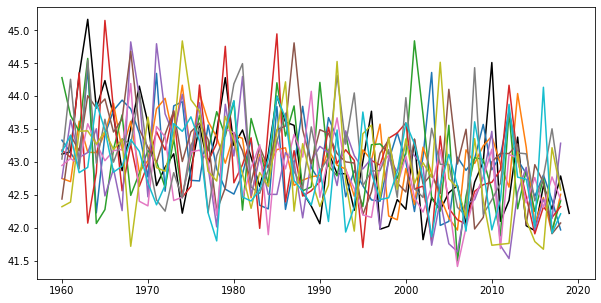

In [19]:
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the observed data
obs_demand_NDJFM["United_Kingdom_demand"].plot(ax=ax, label="Observed", color="black")

# loop over the unique members in the model data
for member in model_demand_NDJFM["member"].unique():
    # constrain to the current member
    model_demand_NDJFM_member = model_demand_NDJFM.loc[model_demand_NDJFM["member"] == member]

    # Plot the model data
    model_demand_NDJFM_member["United_Kingdom_demand"].plot(ax=ax, label=f"Model member {member}")

All have a linear trend from climate change signal, remove this then explore anomalies.

In [20]:
# apply a linear detrend to the observed data
from scipy import signal

obs_demand_NDJFM["United_Kingdom_demand_detrended"] = signal.detrend(obs_demand_NDJFM["United_Kingdom_demand"])

In [21]:
# Apply a linear detrend to the model data
model_demand_NDJFM["United_Kingdom_demand_detrended"] = signal.detrend(model_demand_NDJFM["United_Kingdom_demand"])

In [22]:
# add a new column to the observations dataframe
# for the normalised anomalies of detrended united kingdom demand
obs_demand_NDJFM["United_Kingdom_demand_detrended_anom"] = (obs_demand_NDJFM["United_Kingdom_demand_detrended"] - obs_demand_NDJFM["United_Kingdom_demand_detrended"].mean()) / obs_demand_NDJFM["United_Kingdom_demand_detrended"].std()

In [23]:
# add a new column to the model dataframe
# for the normalised anomalies of detrended united kingdom demand
# grouped by member
model_demand_NDJFM["United_Kingdom_demand_detrended_anom"] = model_demand_NDJFM.groupby("member")["United_Kingdom_demand_detrended"].transform(lambda x: (x - x.mean()) / x.std())

In [24]:
model_demand_NDJFM.head()

,member,United_Kingdom_tas,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand,United_Kingdom_demand_detrended,United_Kingdom_demand_detrended_anom
1960,r7i1p1f2,4.428282,11.071718,0.0,43.333399,-0.063108,-0.174918
1960,r1i1p1f2,5.206377,10.293623,0.0,42.751689,-0.643453,-1.419636
1960,r6i1p1f2,3.158589,12.341411,0.0,44.282633,0.888856,1.263330
1960,r2i1p1f2,4.630105,10.869895,0.0,43.182515,-0.209897,-0.294633
1960,r4i1p1f2,5.200538,10.299462,0.0,42.756054,-0.634992,-0.861491


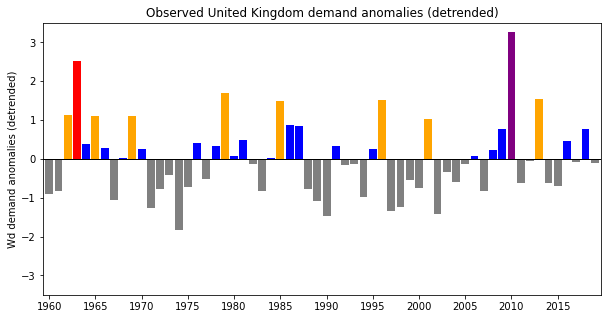

In [25]:
# plot the observed demand anomalies
# set up the positive conditions for these
positive_conditions_demand_obs = [
    (obs_demand_NDJFM["United_Kingdom_demand_detrended_anom"] >= 0)
    & (obs_demand_NDJFM["United_Kingdom_demand_detrended_anom"] <= 1),
    (obs_demand_NDJFM["United_Kingdom_demand_detrended_anom"] >= 1)
    & (obs_demand_NDJFM["United_Kingdom_demand_detrended_anom"] <= 2),
    (obs_demand_NDJFM["United_Kingdom_demand_detrended_anom"] >= 2)
    & (obs_demand_NDJFM["United_Kingdom_demand_detrended_anom"] <= 3),
    (obs_demand_NDJFM["United_Kingdom_demand_detrended_anom"] > 3),
    (obs_demand_NDJFM["United_Kingdom_demand_detrended_anom"] < 0),
]

# Set up the colours for these
colors = ["blue", "orange", "red", "purple", "gray"]

# Set up the labels for these
obs_demand_NDJFM["colour"] = np.select(positive_conditions_demand_obs, colors, default="black")

# if colour in the dataframe, plot the data
if "colour" in obs_demand_NDJFM.columns:
    # set up the figure
    fig, ax = plt.subplots(figsize=(10, 5))

    # plot the observed data as bars
    obs_demand_NDJFM["United_Kingdom_demand_detrended_anom"].plot.bar(ax=ax, color=obs_demand_NDJFM["colour"], width=0.85)

    # Set up a horizontal line at 0
    ax.axhline(0, color="black", linewidth=1)

    # Set the title
    ax.set_title("Observed United Kingdom demand anomalies (detrended)")

    # Set the ylims
    ax.set_ylim(-3.5, 3.5)

    # Only plot the xlabels very 5 years
    ax.set_xticks(ax.get_xticks()[::5])

    # # Tilt the ticks to make them more readable
    plt.xticks(rotation=360)

    # Set the ylabel
    ax.set_ylabel("Wd demand anomalies (detrended)")

In [164]:
obs_demand_NDJFM.head()

,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand,United_Kingdom_demand_detrended,United_Kingdom_demand_detrended_anom,colour,colour_detrend
1960,4.710311,10.789689,0.0,43.122552,-0.558974,-0.909591,gray,gray
1961,4.666789,10.833211,0.0,43.155090,-0.502871,-0.818296,gray,gray
1962,3.104475,12.395525,0.0,44.323089,0.688694,1.120678,orange,orange
1963,1.975372,13.524628,0.0,45.167216,1.556388,2.532633,red,red
1964,3.774322,11.725678,0.0,43.822306,0.235044,0.382475,blue,blue


In [ ]:
# calculate the mean united kingdom demand
obs_demand_NDJFM["United_Kingdom_demand_anom"] = (obs_demand_NDJFM["United_Kingdom_demand"] - obs_demand_NDJFM["United_Kingdom_demand"].mean())

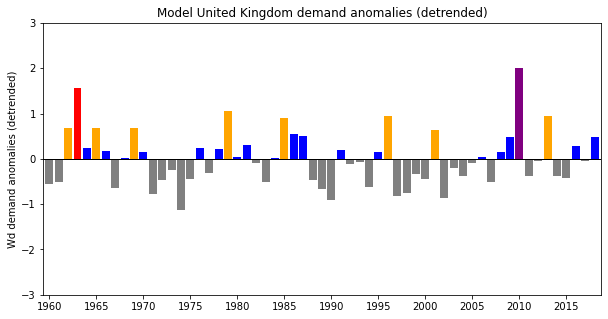

In [166]:
# set up the conditions for plotting the detrended model data
positive_conditions_detrend_model = [
    ((obs_demand_NDJFM["United_Kingdom_demand_detrended"] > 0) & (obs_demand_NDJFM["United_Kingdom_demand_detrended"] < 1*np.std(obs_demand_NDJFM["United_Kingdom_demand_detrended"]))),
    ((obs_demand_NDJFM["United_Kingdom_demand_detrended"] > 1*np.std(obs_demand_NDJFM["United_Kingdom_demand_detrended"])) & (obs_demand_NDJFM["United_Kingdom_demand_detrended"] < 2*np.std(obs_demand_NDJFM["United_Kingdom_demand_detrended"]))),
    ((obs_demand_NDJFM["United_Kingdom_demand_detrended"] > 2*np.std(obs_demand_NDJFM["United_Kingdom_demand_detrended"])) & (obs_demand_NDJFM["United_Kingdom_demand_detrended"] < 3*np.std(obs_demand_NDJFM["United_Kingdom_demand_detrended"]))),
    (obs_demand_NDJFM["United_Kingdom_demand_detrended"] > 3*np.std(obs_demand_NDJFM["United_Kingdom_demand_detrended"])),
    (obs_demand_NDJFM["United_Kingdom_demand_detrended"] < 0),
]

# Set up the colours for these
colors = ["blue", "orange", "red", "purple", "gray"]

# Set up the labels for these
obs_demand_NDJFM["colour_detrend"] = np.select(positive_conditions_detrend_model, colors, default="black")

# if colour_detrend in the dataframe, plot the data
if "colour_detrend" in obs_demand_NDJFM.columns:
    # set up the figure
    fig, ax = plt.subplots(figsize=(10, 5))

    # plot the model data as bars
    obs_demand_NDJFM["United_Kingdom_demand_detrended"].plot.bar(ax=ax, color=obs_demand_NDJFM["colour_detrend"], width=0.85)

    # Set up a horizontal line at 0
    ax.axhline(0, color="black", linewidth=1)

    # Set the title
    ax.set_title("Model United Kingdom demand anomalies (detrended)")

    # Set the ylims
    ax.set_ylim(-3.0, 3.0)

    # Only plot the xlabels very 5 years
    ax.set_xticks(ax.get_xticks()[::5])

    # # Tilt the ticks to make them more readable
    plt.xticks(rotation=360)

    # Set the ylabel
    ax.set_ylabel("Wd demand anomalies (detrended)")


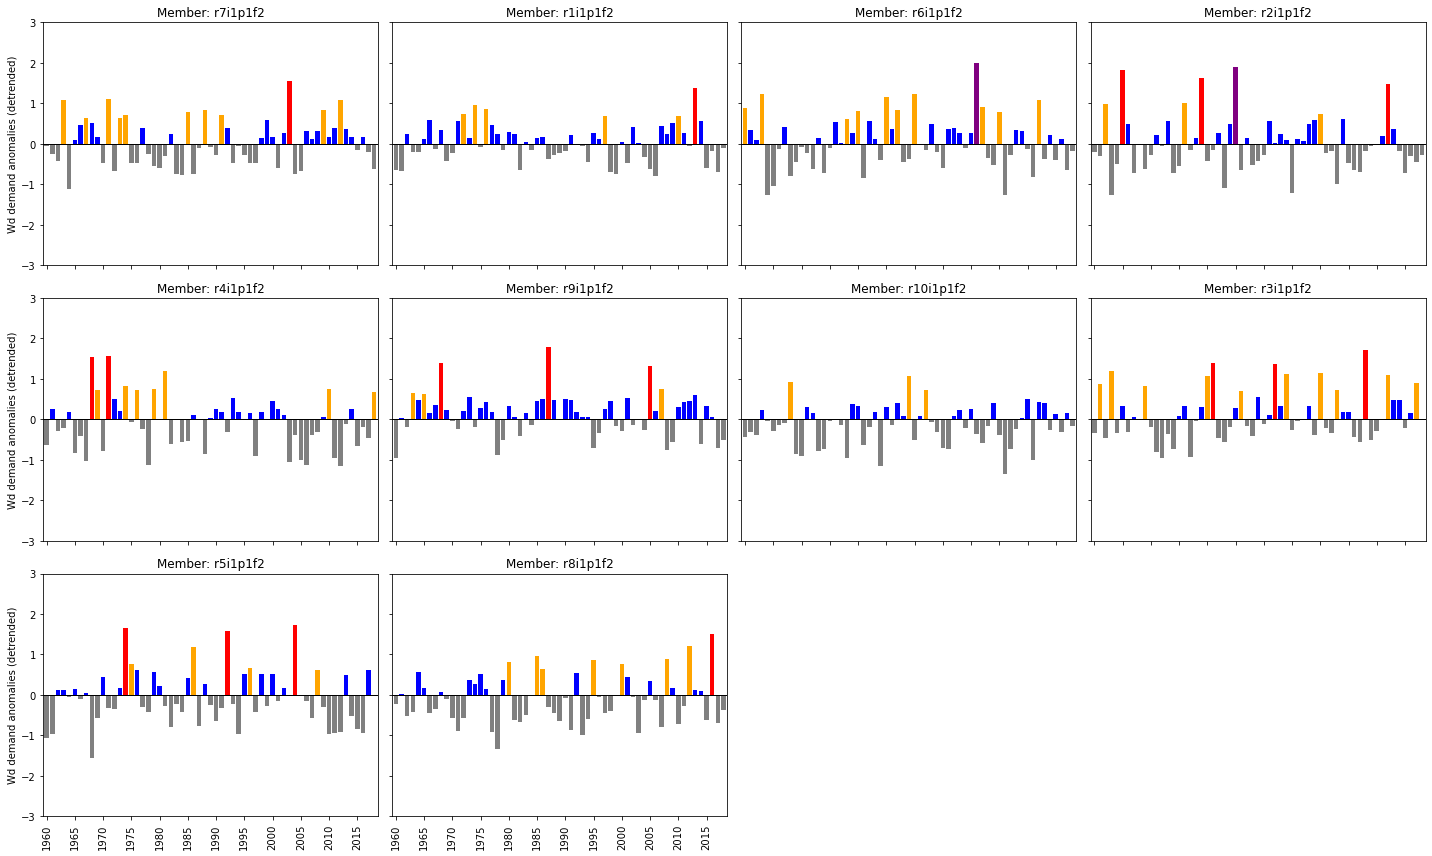

In [169]:
positive_conditions_detrend_model_comparison = [
    ((model_demand_NDJFM["United_Kingdom_demand_detrended"] >= 0) & (model_demand_NDJFM["United_Kingdom_demand_detrended"] < 1*np.std(obs_demand_NDJFM["United_Kingdom_demand_detrended"]))),
    ((model_demand_NDJFM["United_Kingdom_demand_detrended"] >= 1*np.std(obs_demand_NDJFM["United_Kingdom_demand_detrended"])) & (model_demand_NDJFM["United_Kingdom_demand_detrended"] < 2*np.std(obs_demand_NDJFM["United_Kingdom_demand_detrended"]))),
    ((model_demand_NDJFM["United_Kingdom_demand_detrended"] >= 2*np.std(obs_demand_NDJFM["United_Kingdom_demand_detrended"])) & (model_demand_NDJFM["United_Kingdom_demand_detrended"] < 3*np.std(obs_demand_NDJFM["United_Kingdom_demand_detrended"]))),
    (model_demand_NDJFM["United_Kingdom_demand_detrended"] >= 3*np.std(obs_demand_NDJFM["United_Kingdom_demand_detrended"])),
    (model_demand_NDJFM["United_Kingdom_demand_detrended"] < 0),
]


# use these same positive conditions for the model data
model_demand_NDJFM["colour_detrend"] = np.select(positive_conditions_detrend_model_comparison, colors, default="black")

if "colour_detrend" in model_demand_NDJFM.columns:
    # set up the figure
    fig, axs = plt.subplots(3, 4, figsize=(20, 12), sharex=True, sharey=True)

    # loop over the unique members in the model data
    for member, ax in zip(model_demand_NDJFM["member"].unique(), axs.flatten()):
        # constrain to the current member
        model_demand_NDJFM_member = model_demand_NDJFM.loc[model_demand_NDJFM["member"] == member]

        # plot the model data as bars
        model_demand_NDJFM_member["United_Kingdom_demand_detrended"].plot.bar(ax=ax, color=model_demand_NDJFM_member["colour_detrend"], width=0.80)

        # Set up a horizontal line at 0
        ax.axhline(0, color="black", linewidth=1)

        # Set the title
        ax.set_title(f"Member: {member}")

        # Set the ylims
        ax.set_ylim(-3.0, 3.0)

        # Only plot the xlabels very 5 years
        ax.set_xticks(ax.get_xticks()[::5])

        # # Tilt the ticks to make them more readable
        plt.xticks(rotation=360)

        # Set the ylabel
        ax.set_ylabel("Wd demand anomalies (detrended)")

# remove the subplots that are not used
for ax in axs.flatten()[len(model_demand_NDJFM["member"].unique()):]:
    fig.delaxes(ax)

# specify a tight layout
plt.tight_layout()

Text(0.5, 1.0, 'Histogram of detrended United Kingdom demand')

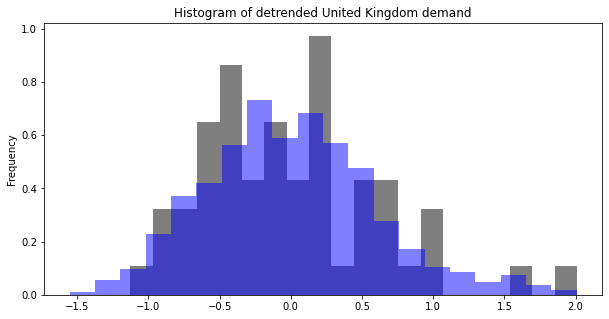

In [172]:
fig, ax = plt.subplots(figsize=(10, 5))

# plot the observed data as a histogram
obs_demand_NDJFM["United_Kingdom_demand_detrended"].plot.hist(ax=ax, bins=20, alpha=0.5, label="Observed", color="black", density=True)

# loop over the unique members in the model data
model_demand_NDJFM["United_Kingdom_demand_detrended"].plot.hist(ax=ax, bins=20, alpha=0.5, label="Model", color="blue", density=True)

# set a heading
ax.set_title("Histogram of detrended United Kingdom demand")

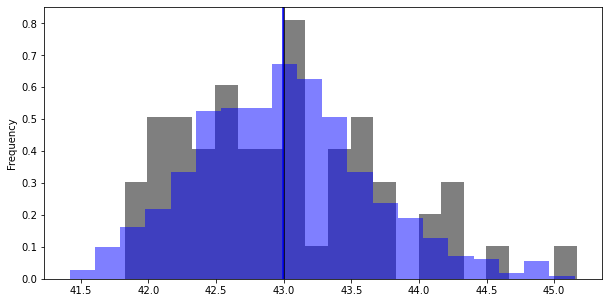

In [175]:
# do the same but for absolute demand
fig, ax = plt.subplots(figsize=(10, 5))

# plot the observed data as a histogram
obs_demand_NDJFM["United_Kingdom_demand"].plot.hist(ax=ax, bins=20, alpha=0.5, label="Observed", color="black", density=True)

# plot the mean of the obs as a black vertical line
ax.axvline(obs_demand_NDJFM["United_Kingdom_demand"].mean(), color="black", label="Observed mean")

# plot the model data as a histogram
model_demand_NDJFM["United_Kingdom_demand"].plot.hist(ax=ax, bins=20, alpha=0.5, label="Model", color="blue", density=True)

# plot the mean of the model as a blue vertical line
ax.axvline(model_demand_NDJFM["United_Kingdom_demand"].mean(), color="blue", label="Model mean")

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (1).

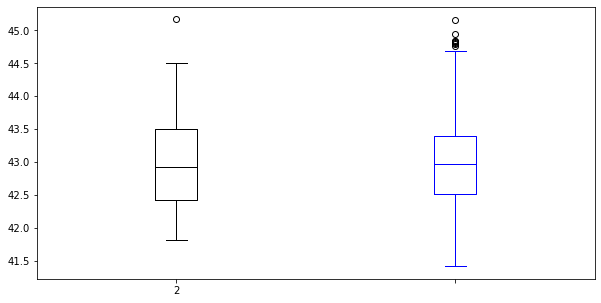

In [178]:
# plot these two as boxplots
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# plot the observed data as a boxplot
obs_demand_NDJFM["United_Kingdom_demand"].plot.box(ax=ax, positions=[1], label="Observed", color="black")

# plot the model data as a boxplot
model_demand_NDJFM["United_Kingdom_demand"].plot.box(ax=ax, positions=[2], label="Model", color="blue")

# set the title
ax.set_title("Boxplot of United Kingdom demand")

# set the ticks
ax.set_xticks([1, 2])

# set the tick labels
ax.set_xticklabels(['Observed', 'Model'])

In [179]:
# print the maximum and minimum values of the observed data
print("Observed max:", obs_demand_NDJFM["United_Kingdom_demand"].max())

print("Observed min:", obs_demand_NDJFM["United_Kingdom_demand"].min())

# print the maximum and minimum values of the model data
print("Model max:", model_demand_NDJFM["United_Kingdom_demand"].max())

print("Model min:", model_demand_NDJFM["United_Kingdom_demand"].min())

Observed max: 45.167216280639416
Observed min: 41.82344423984461
Model max: 45.15046347677195
Model min: 41.41662705439237


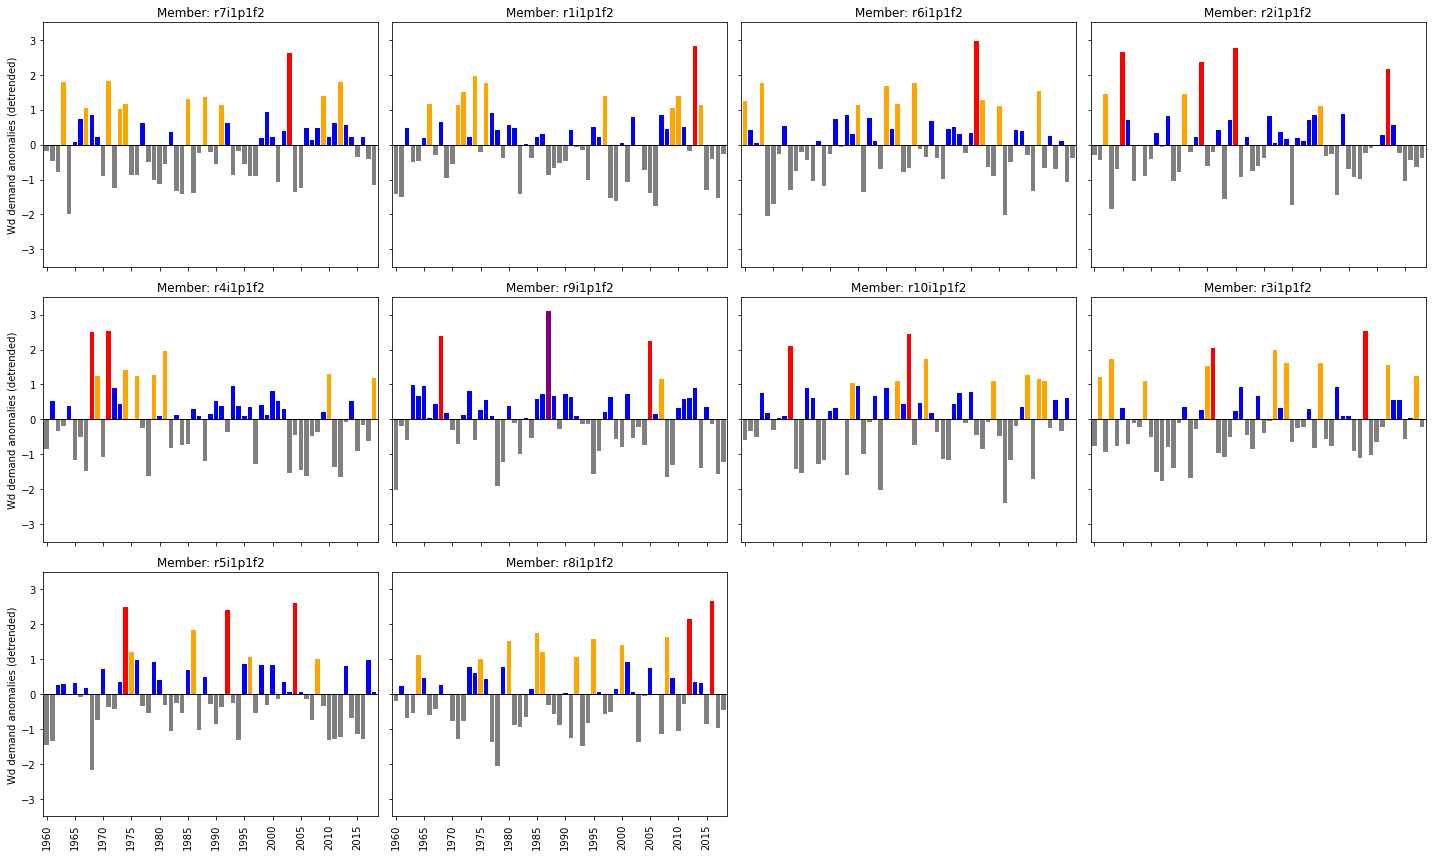

In [26]:
# Do the same for the model data

# set up the positive conditions for these
positive_conditions_demand_model = [
    (model_demand_NDJFM["United_Kingdom_demand_detrended_anom"] >= 0)
    & (model_demand_NDJFM["United_Kingdom_demand_detrended_anom"] <= 1),
    (model_demand_NDJFM["United_Kingdom_demand_detrended_anom"] >= 1)
    & (model_demand_NDJFM["United_Kingdom_demand_detrended_anom"] <= 2),
    (model_demand_NDJFM["United_Kingdom_demand_detrended_anom"] >= 2)
    & (model_demand_NDJFM["United_Kingdom_demand_detrended_anom"] <= 3),
    (model_demand_NDJFM["United_Kingdom_demand_detrended_anom"] > 3),
    (model_demand_NDJFM["United_Kingdom_demand_detrended_anom"] < 0),
]

# Set up the colours for these
colors = ["blue", "orange", "red", "purple", "gray"]

# Set up the labels for these
model_demand_NDJFM["colour"] = np.select(positive_conditions_demand_model, colors, default="black")

# if colour in the dataframe, plot the data
if "colour" in model_demand_NDJFM.columns:
    # set up the figure
    # as 3 rows x 4 columns
    fig, axs = plt.subplots(3, 4, figsize=(20, 12), sharex=True, sharey=True)

    # loop over the unique members in the model data
    for i, member in enumerate(model_demand_NDJFM["member"].unique()):
        # constrain to the current member
        model_demand_NDJFM_member = model_demand_NDJFM.loc[model_demand_NDJFM["member"] == member]

        # plot the observed data as bars
        model_demand_NDJFM_member["United_Kingdom_demand_detrended_anom"].plot.bar(ax=axs.flatten()[i], color=model_demand_NDJFM_member["colour"], width=0.80)

        # Set up a horizontal line at 0
        axs.flatten()[i].axhline(0, color="black", linewidth=1)

        # Set the title
        axs.flatten()[i].set_title(f"Member: {member}")

        # Set the ylims
        axs.flatten()[i].set_ylim(-3.5, 3.5)

        # Only plot the xlabels very 5 years
        axs.flatten()[i].set_xticks(axs.flatten()[i].get_xticks()[::5])

        # # Tilt the ticks to make them more readable
        plt.xticks(rotation=360)

        # Set the ylabel
        axs.flatten()[i].set_ylabel("Wd demand anomalies (detrended)")

# remove the sublots that are not used
for i in range(10, 12):
    fig.delaxes(axs.flatten()[i])

# Specify a tight layout
plt.tight_layout()

### EVA on demand anomalies ###

We want to estimate the return period of the 2010 'demand' event. How unusual is this relative to the other events we have available. We want to estimate this in two ways:

* Using just the obs data
* Using the model data

In [68]:
import matplotlib.ticker as ticker

# define a function to plot the events and return periods
def plot_evt(
    obs_df: pd.DataFrame,
    model_df: pd.DataFrame,
    obs_col: str,
    model_col: str,
    unc_range: list = [0.025, 0.975],
    nboot: int = 1000,
    fontsize: int = 12,
    figsize: tuple = (10, 8),
    save_dir: str = "/gws/nopw/j04/canari/users/benhutch/plots/",
):
    """
    Function which plots the values for a variable of interest on the x-axis and the chance of event (%) on the y-axis. Function plots the range of uncertainty using just the obs data, the range of uncertainty when the model is sampled to the length of the observed data and the full range of uncertainty using the model data.

    Args:
        obs_df (pd.DataFrame): DataFrame containing the observed data
        model_df (pd.DataFrame): DataFrame containing the model data
        obs_col (str): Column name in the observed DataFrame
        model_col (str): Column name in the model DataFrame
        unc_range (list, optional): Range for the uncertainty. Defaults to [0.025, 0.975].
        nboot (int, optional): Number of bootstraps to use. Defaults to 1000.
        fontsize (int, optional): Fontsize for the plot. Defaults to 12.
        figsize (tuple, optional): Figure size. Defaults to (10, 8).
        save_dir (str, optional): Directory to save the plot. Defaults to "/gws/nopw/j04/canari/users/benhutch/plots/".

    Returns:
        None

    """

    # extract the first unique member from the model data
    model_member = model_df["member"].unique()[0]

    # # print the len of the model data when constrained to the first member
    # print(f"Length of model data: {len(model_df.loc[model_df['member'] == model_member])}")

    # # print the length of the observed data
    # print(f"Length of observed data: {len(obs_df)}")

    # assert that the length of the observed data is the same as the
    # model data when constrained to the first member
    assert len(obs_df) == len(
        model_df.loc[model_df["member"] == model_member]
    ), "Length of observed data and model data do not match"

    # Set up the length of the observed data
    obs_len = len(obs_df)

    # print the observed length
    print(f"Length of observed data: {obs_len}")

    # TODO: Set a threshold for demand extremes? How to do this?
    # First pass - set the threshold as the 75th percentile of the observed data
    obs_threshold = obs_df[obs_col].quantile(0.50)

    # print the threshold
    print(f"Threshold from obs: {obs_threshold}")

    # Set up the bootstrap array
    # e.g. with len (1000, len(obs_df)) for 1000 bootstrap samples
    boot_obs = np.zeros([nboot, len(obs_df)])

    # Set up the bootstrapped array for model data
    # resample to len obs
    boot_model_len_obs = np.zeros([nboot, len(obs_df)])

    # Set up the bootstrapped array for model data
    # resample to full length
    boot_model_full = np.zeros([nboot, len(model_df)])

    # loop over the number of bootstraps
    for i in tqdm(range(nboot)):
        # sample the observed data with replacement
        boot_obs[i, :] = np.random.choice(
            obs_df[obs_col], size=len(obs_df), replace=True
        )

        # Any values below the threshold are set to NaN
        boot_obs[i, boot_obs[i, :] < obs_threshold] = np.nan

        # sample the model data with replacement
        boot_model_len_obs[i, :] = np.random.choice(
            model_df[model_col], size=len(obs_df), replace=True
        )

        # Any values below the threshold are set to NaN
        boot_model_len_obs[i, boot_model_len_obs[i, :] < obs_threshold] = np.nan

        # sample the model data with replacement
        boot_model_full[i, :] = np.random.choice(
            model_df[model_col], size=len(model_df), replace=True
        )

        # Any values below the threshold are set to NaN
        boot_model_full[i, boot_model_full[i, :] < obs_threshold] = np.nan

    # print boot obs
    print("boot obs: ", boot_obs)

    # assert that not all values of boot obs are NaN
    assert not np.all(np.isnan(boot_obs)), "All values of boot obs are NaN"

    # assert that not all values of boot model len obs are NaN
    assert not np.all(np.isnan(boot_model_len_obs)), "All values of boot model len obs are NaN"

    # assert that not all values of boot model full are NaN
    assert not np.all(np.isnan(boot_model_full)), "All values of boot model full are NaN"

    # Calculate the return periods
    rps_obs_len = obs_len / np.arange(1, obs_len + 1)
    rps_model_len = len(model_df) / np.arange(1, len(model_df) + 1)

    # calculate the chance of occurenece - 1/rps
    chance_obs_len = (1 / rps_obs_len) * 100
    chance_model_len = (1 / rps_model_len) * 100

    # print the rps obs
    print("rps obs: ", rps_obs_len)

    # Calculate the return values for each bootstrapped sample
    rvs_obs = np.nanquantile(boot_obs, q=1 - 1 / rps_obs_len, axis=0)
    rvs_model_obs_len = np.nanquantile(boot_model_len_obs, q=1 - 1 / rps_obs_len, axis=0)
    rvs_model_full = np.nanquantile(boot_model_full, q=1 - 1 / rps_model_len, axis=0)

    # print the rvs obs
    print("rvs obs: ", rvs_obs)

    # print rvs obs shape
    print("rvs obs shape: ", rvs_obs.shape)

    # print rvs model obs len
    print("rvs model obs len: ", rvs_model_obs_len)

    # print rvs model obs len shape
    print("rvs model obs len shape: ", rvs_model_obs_len.shape)

    # assert that not all values of rvs obs are NaN
    assert not np.all(np.isnan(rvs_obs)), "All values of rvs obs are NaN"

    # Calculate the uncertainty range
    ci_return_obs = np.nanquantile(rvs_obs, q=unc_range, axis=1)
    ci_return_model_len_obs = np.nanquantile(rvs_model_obs_len, q=unc_range, axis=1)
    ci_return_model_full = np.nanquantile(rvs_model_full, q=unc_range, axis=1)

    # print ci_return_obs
    print("ci_return_obs: ", ci_return_obs)

    # print ci_return_model_full
    print("ci_return_model_full: ", ci_return_model_full)

    print("ci_return_model_len_obs: ", ci_return_model_len_obs)

    # extract the ci_25 and ci_975
    ci_25_obs, ci_975_obs = ci_return_obs
    ci_25_model_len_obs, ci_975_model_len_obs = ci_return_model_len_obs
    ci_25_model_full, ci_975_model_full = ci_return_model_full

    # Set up the plot
    # Set up the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the observed data as the 2.5th and 97.5th percentiles
    # with return periods on the y-axis
    ax.plot(ci_25_obs, chance_obs_len, color="blue", label="2.5th percentile")
    ax.plot(ci_975_obs, chance_obs_len, color="blue", label="97.5th percentile")

    # Plot the model data resampled to the length of the observed data
    # as the 2.5th and 97.5th percentiles with return periods on the y-axis
    ax.plot(ci_25_model_len_obs, chance_obs_len, color="grey", label="Lower bound")
    ax.plot(ci_975_model_len_obs, chance_obs_len, color="grey", label="Upper bound")

    # Plot the model data resampled to the full length
    # as the 2.5th and 97.5th percentiles with return periods on the y-axis
    ax.fill_betweenx(
        chance_model_len,
        ci_25_model_full,
        ci_975_model_full,
        color="red",
        alpha=0.5,
        label="Model (full length)",
    )

    # include a legend
    ax.legend()

    # set y-axis to logarithmic scale
    ax.set_yscale("log")

    # specify the points which should be marked on the y-axis
    yticks = [1, 2, 5, 10, 15, 30, 40]

    # mark the points on the y-axis
    ax.set_yticks(yticks)

    # format the y-ticks as integers
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

    # limit y-axis between 34 and 1
    ax.set_ylim(0, 45)

    # constrain the x-axis to the length of the observed data
    ax.set_xlim(43, 45.5)

    # include a dashed line at 1
    ax.axhline(1, color="black", linestyle="--")

    # # limit y-axis to 100
    # ax.set_ylim(1, 50)

    # # invert the y-axis
    # ax.invert_yaxis()

    # print("Exiting")
    # sys.exit()



In [69]:
# # remove 2019 row from the observed data
# obs_demand_NDJFM.drop(2019, inplace=True)

Length of observed data: 59
Threshold from obs: 42.921959344673624


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9596.43it/s]

boot obs:  [[43.00925085 43.12255218         nan ... 44.32308854 43.48797356
  43.82230578]
 [43.126112   43.54884197         nan ...         nan         nan
          nan]
 [        nan         nan         nan ... 43.14934755 43.25240249
          nan]
 ...
 [43.00473027         nan         nan ...         nan 43.07558629
  43.14934755]
 [43.77232787         nan 43.46570834 ...         nan 43.55822007
          nan]
 [        nan         nan 43.126112   ...         nan 44.15326212
  43.70598631]]
rps obs:  [59.         29.5        19.66666667 14.75       11.8         9.83333333
  8.42857143  7.375       6.55555556  5.9         5.36363636  4.91666667
  4.53846154  4.21428571  3.93333333  3.6875      3.47058824  3.27777778
  3.10526316  2.95        2.80952381  2.68181818  2.56521739  2.45833333
  2.36        2.26923077  2.18518519  2.10714286  2.03448276  1.96666667
  1.90322581  1.84375     1.78787879  1.73529412  1.68571429  1.63888889
  1.59459459  1.55263158  1.51282051  1.475      

rvs obs:  [[45.16721628 45.16721628 45.16721628 ... 45.16721628 45.16721628
  45.16721628]
 [44.51166831 45.16721628 44.51166831 ... 45.16721628 44.51166831
  44.51166831]
 [44.51166831 44.51166831 44.46052803 ... 44.51166831 44.51166831
  44.51166831]
 ...
 [42.96009813 42.92259272 42.92195934 ... 42.92195934 42.95932861
  42.95932861]
 [42.95932861 42.92195934 42.92195934 ... 42.92195934 42.92195934
  42.92195934]
 [42.92195934 42.92195934 42.92195934 ... 42.92195934 42.92195934
  42.92195934]]
rvs obs shape:  (59, 59)
rvs model obs len:  [[44.81020106 44.81020106 44.79822983 ... 44.77705039 44.76269991
  44.79687459]
 [44.51638191 44.56769171 44.57390752 ... 44.36077422 44.42795357
  44.4334457 ]
 [44.35468536 44.3571377  44.4334457  ... 44.28459175 44.28263254
  44.31916638]
 ...
 [42.95377435 42.95642284 42.9595627  ... 42.95580082 42.9539225
  42.94584022]
 [42.93956841 42.94808207 42.94584022 ... 42.94477296 42.94297801
  42.93956841]
 [42.92470147 42.92470147 42.92470147 ... 42

/tmp/ipykernel_17051/3526340486.py:202: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, 45)


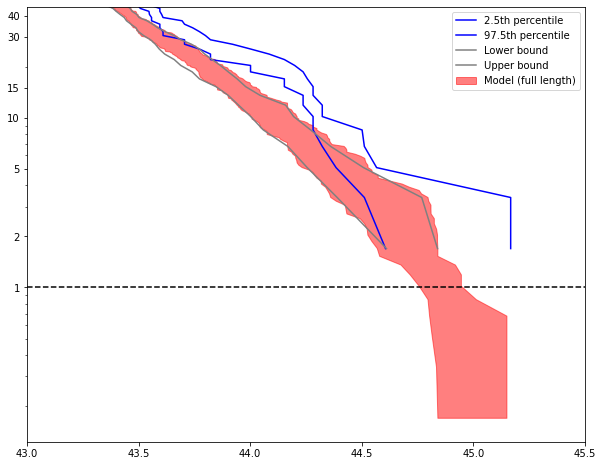

In [70]:
# test the function
plot_evt(
    obs_df=obs_demand_NDJFM,
    model_df=model_demand_NDJFM,
    obs_col="United_Kingdom_demand", # not detrended data
    model_col="United_Kingdom_demand", # want absolute values
    unc_range=[0.025, 0.975],
    nboot=1000,
    fontsize=12,
    figsize=(10, 8),
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/",
)

In [90]:
import matplotlib.ticker as ticker
import scipy.stats as stats

def plot_evt_gpd(
    obs_df: pd.DataFrame,
    model_df: pd.DataFrame,
    obs_col: str,
    model_col: str,
    unc_range: list = [0.025, 0.975],
    nboot: int = 1000,
    fontsize: int = 12,
    figsize: tuple = (10, 8),
    save_dir: str = "/gws/nopw/j04/canari/users/benhutch/plots/",
):
    """
    Plots the extreme value theory (EVT) using a Generalised Pareto Distribution (GPD) fitted to observations.

    Parameters:

        obs_df (pd.DataFrame): DataFrame containing the observed data.
        model_df (pd.DataFrame): DataFrame containing the model data.
        obs_col (str): Column name of the observed data in obs_df.
        model_col (str): Column name of the model data in model_df.
        unc_range (list, optional): List containing the lower and upper percentiles for the uncertainty range. Defaults to [0.025, 0.975].
        nboot (int, optional): Number of bootstrap samples to generate. Defaults to 1000.
        fontsize (int, optional): Font size for the plot. Defaults to 12.
        figsize (tuple, optional): Size of the figure for the plot. Defaults to (10, 8).
        save_dir (str, optional): Directory to save the plot. Defaults to "/gws/nopw/j04/canari/users/benhutch/plots/".

    Returns:

        None. The function saves the plot to the specified directory.

    """

    # extract the first unique member from the model data
    model_member = model_df["member"].unique()[0]

    # assert that the length of the observed data is the same as the
    # model data when constrained to the first member
    assert len(obs_df) == len(
        model_df.loc[model_df["member"] == model_member]
    ), "Length of observed data and model data do not match"

    # Set up the length of the observed data
    obs_len = len(obs_df)

    # print the observed length
    print(f"Length of observed data: {obs_len}")

    # TODO: Set a threshold for demand extremes? How to do this?
    # First pass - set the threshold as the 75th percentile of the observed data
    obs_threshold = obs_df[obs_col].quantile(0.50)

    # print the threshold
    print(f"Threshold from obs: {obs_threshold}")

    # Set up the bootstrap array
    # e.g. with len (1000, len(obs_df)) for 1000 bootstrap samples
    boot_obs = np.zeros([nboot, len(obs_df)])

    # Set up the bootstrapped array for model data
    # resample to len obs
    boot_model_len_obs = np.zeros([nboot, len(obs_df)])

    # Set up the bootstrapped array for model data
    # resample to full length
    boot_model_full = np.zeros([nboot, len(model_df)])

    # loop over the number of bootstraps
    for i in tqdm(range(nboot)):
        # Create a boolean mask for values above the threshold
        mask = obs_df[obs_col] > obs_threshold

        # Sample the observed data with replacement, only for values above the threshold
        boot_obs[i, :] = np.random.choice(
            obs_df[obs_col][mask], size=len(obs_df), replace=True
        )

        # # remove Nan values
        # boot_obs = boot_obs[~np.isnan(boot_obs).all(axis=1)]

        # # print boot obs
        # print("boot obs: ", boot_obs[i, :])

        # Fit a GPD to the bootstrapped observed data
        try:
            params = stats.genpareto.fit(boot_obs[i, :])
        except RuntimeError:
            continue  # Skip this bootstrap if the fit did not converge

    # Calculate the return periods
    rps_obs_len = obs_len / np.arange(1, obs_len + 1)
    rps_model_len = len(model_df) / np.arange(1, len(model_df) + 1)

    # calculate the chance of occurenece - 1/rps
    chance_obs_len = (1 / rps_obs_len) * 100
    chance_model_len = (1 / rps_model_len) * 100

    # calculate the 2.5% and 97.5% percentiles for the return values
    # using the Generalised Pareto Distribution (GPD)
    rvs_obs_25 = stats.genpareto.ppf(0.025, *params)

    # print the rvs obs 25
    print("rvs obs 25: ", rvs_obs_25)

    # Calculate the 97.5% percentile for the return values
    rvs_obs_975 = stats.genpareto.ppf(0.975, *params)

    # print the rvs obs 975
    print("rvs obs 975: ", rvs_obs_975)

    # Calculate the return values for each bootstrapped sample
    rvs_obs = stats.genpareto.ppf(1 - 1 / rps_obs_len, *params)
    rvs_model_obs_len = np.nanquantile(boot_model_len_obs, q=1 - 1 / rps_obs_len, axis=0)
    rvs_model_full = np.nanquantile(boot_model_full, q=1 - 1 / rps_model_len, axis=0)

    print("rvs obs: ", rvs_obs)

    # print the rvs model obs len
    print("rvs model obs len: ", rvs_model_obs_len)

    sys.exit()

    # Calculate the uncertainty range
    ci_return_obs = np.nanquantile(rvs_obs, q=unc_range, axis=1)
    ci_return_model_len_obs = np.nanquantile(rvs_model_obs_len, q=unc_range, axis=1)
    ci_return_model_full = np.nanquantile(rvs_model_full, q=unc_range, axis=1)

    # extract the ci_25 and ci_975
    ci_25_obs, ci_975_obs = ci_return_obs
    ci_25_model_len_obs, ci_975_model_len_obs = ci_return_model_len_obs
    ci_25_model_full, ci_975_model_full = ci_return_model_full


    # Set up the plot
    # Set up the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the observed data as the 2.5th and 97.5th percentiles
    # with return periods on the y-axis
    ax.plot(ci_25_obs, chance_obs_len, color="blue", label="2.5th percentile")
    ax.plot(ci_975_obs, chance_obs_len, color="blue", label="97.5th percentile")

    # Plot the model data resampled to the length of the observed data
    # as the 2.5th and 97.5th percentiles with return periods on the y-axis
    ax.plot(ci_25_model_len_obs, chance_obs_len, color="grey", label="Lower bound")
    ax.plot(ci_975_model_len_obs, chance_obs_len, color="grey", label="Upper bound")

    # Plot the model data resampled to the full length
    # as the 2.5th and 97.5th percentiles with return periods on the y-axis
    ax.fill_betweenx(
        chance_model_len,
        ci_25_model_full,
        ci_975_model_full,
        color="red",
        alpha=0.5,
        label="Model (full length)",
    )

    # include a legend
    ax.legend()

    # set y-axis to logarithmic scale
    ax.set_yscale("log")

    # specify the points which should be marked on the y-axis
    yticks = [1, 2, 5, 10, 15, 30, 40]

    # mark the points on the y-axis
    ax.set_yticks(yticks)

    # format the y-ticks as integers
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

    # limit y-axis between 34 and 1
    ax.set_ylim(0, 45)

    # constrain the x-axis to the length of the observed data
    ax.set_xlim(43, 45.5)

    # include a dashed line at 1
    ax.axhline(1, color="black", linestyle="--")

    # # limit y-axis to 100
    # ax.set_ylim(1, 50)

    # # invert the y-axis
    # ax.invert_yaxis()

    # print("Exiting")
    # sys.exit()

In [91]:
# test the new function
plot_evt_gpd(
    obs_df=obs_demand_NDJFM,
    model_df=model_demand_NDJFM,
    obs_col="United_Kingdom_demand", # not detrended data
    model_col="United_Kingdom_demand", # want absolute values
    unc_range=[0.025, 0.975],
    nboot=100,
    fontsize=12,
    figsize=(10, 8),
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/",
)

Length of observed data: 59
Threshold from obs: 42.921959344673624


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:07<00:00, 12.66it/s]


rvs obs 25:  3.6214082265006247
rvs obs 975:  45.16706239267021
rvs obs:  [45.16717545 45.16678115 45.16547956 45.1625794  45.15728417 45.1487092
 45.13589278 45.11780411 45.09334932 45.06137627 45.0206785  44.96999845
 44.9080303  44.83342234 44.74477911 44.64066326 44.5195972  44.3800646
 44.22051177 44.03934887 43.83495104 43.60565945 43.34978226 43.06559549
 42.75134388 42.40524163 42.02547313 41.61019367 41.15753001 40.66558108
 40.13241843 39.55608689 38.93460496 38.26596541 37.54813566 36.77905823
 35.95665121 35.0788086  34.14340074 33.14827463 32.09125435 30.97014131
 29.78271467 28.52673158 27.19992751 25.80001655 24.32469167 22.771625
 21.13846808 19.42285215 17.62238833 15.73466794 13.75726263 11.6877247
  9.52358725  7.2623644   4.90155153  2.43862541 -0.12895552]
rvs model obs len:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


SystemExit: 

/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [92]:
# simplify this first
# pareto fit to the obs data
# set up the observed threshold
obs_threshold = obs_demand_NDJFM["United_Kingdom_demand"].quantile(0.50)

# print the threshold
print(f"Threshold from obs: {obs_threshold}")

# create an array of the values above the threshold
mask = obs_demand_NDJFM["United_Kingdom_demand"] > obs_threshold
values = obs_demand_NDJFM["United_Kingdom_demand"][mask]

Threshold from obs: 42.921959344673624


<AxesSubplot:>

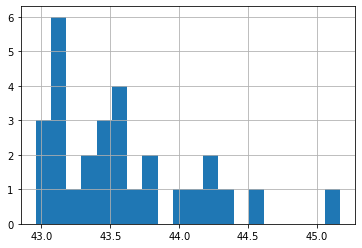

In [93]:
# plot these values as a histogram
fig, ax = plt.subplots()

# plot the histogram
values.hist(ax=ax, bins=20)

(-3.495804079933853, -0.13207021634181648, 158.3574305542395)


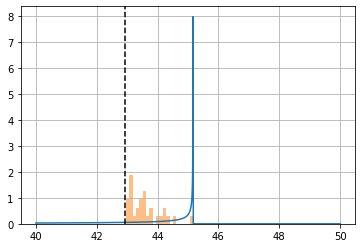

In [105]:
# plot the fitted distribution# Check if the threshold is less than the maximum value in the data
if obs_threshold < np.max(values):
    # Fit a pareto distribution to the data
    params = stats.genpareto.fit(values)

    # print the parameters
    print(params)

    # replace b with 3.5
    params = (-3.495804079933853, params[1], params[2])

    fig, ax = plt.subplots()

    # Plot the histogram and the fitted distribution
    x = np.linspace(40, 50, 1000)

    # Plot the fitted distribution
    # Plot the fitted distribution
    ax.plot(x, stats.genpareto.pdf(x, *params), label="Fitted distribution")

    # Plot the histogram
    values.hist(ax=ax, bins=20, density=True, alpha=0.5, label="Histogram")

    # Plot the threshold
    ax.axvline(obs_threshold, color="black", linestyle="--")
else:
    print("Threshold is greater than the maximum value in the data. Skipping fitting and plotting process.")

In [107]:
from scipy.stats import pareto

b = 2.62
mean, var, skew, kurt = pareto.stats(b, moments='mvsk')

Using the climate match stuff as a clue:

* https://comptools.climatematch.io/tutorials/W2D3_ExtremesandVariability/student/W2D3_Tutorial4.html

Very helpful!

In [110]:
# print the values
print(values.mean(), values.var(), values.skew(), values.kurt())

# print the min and max
print(values.min(), values.max())

43.602079473299895 0.285036484232324 1.1001958052469374 1.122437417199221
42.95932860922453 45.167216280639416


In [137]:
# define a function for calculating the empirical return period
def empirical_return_level(
    data: np.ndarray,
):
    """
    Function to calculate the empirical return level for a given dataset.

    Args:
        data (np.ndarray): Array containing the data of interest.

    Returns:
        np.ndarray: Array containing the empirical return levels.

    """

    # assert that the data is a numpy array
    assert isinstance(data, np.ndarray), "Data must be a numpy array"

    # create a dataframe from the data
    df = pd.DataFrame(index=np.arange(data.size))

    # Sort the data
    df["sorted"] = np.sort(data)[::-1]

    # rank via scipy (notice the negative here)
    df["rank_sp"] = np.sort(stats.rankdata(-data))

    # find the exceedance probability
    n = data.size
    df["exceedance"] = df["rank_sp"] / (n + 1)

    # find the return period
    df["period"] = 1 / df["exceedance"]

    # reverse the order of rows
    df = df[::-1]

    # transform into xarray dataarray
    out = xr.DataArray(
        dims=["period"],
        coords={"period": df["period"]},
        data=df["sorted"],
        name="level",
    )

    return out

In [129]:
# rename values
data = values

In [130]:
from scipy.stats import genextreme as gev

In [131]:
shape, loc, scale = gev.fit(data.values, 0)
print(f"Fitted parameters:\nShape: {shape:.5f}, Location: {loc:.5f}, Scale: {scale:.5f}")

Fitted parameters:
Shape: -0.22273, Location: 43.32429, Scale: 0.34106


In [132]:
def estimate_return_level(quantile, loc, scale, shape):
    level = loc + scale / shape * (1 - (-np.log(quantile)) ** (shape))
    return level

In [133]:
# estimate the return level for the two year return level (0.2)
quantile = 0.98

# estimate the return level
estimate_return_level(quantile, loc, scale, shape)

45.444626552435004

In [134]:
# estimate this using the percent point function
gev.ppf(quantile, shape, loc, scale)

45.444626552435004

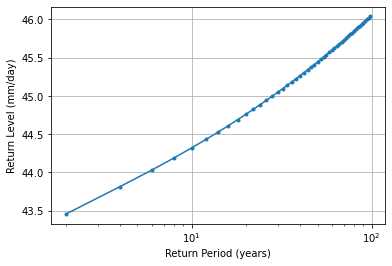

In [135]:
periods = np.arange(2, 100, 2)
quantiles = 1 - 1 / periods
levels = estimate_return_level(quantiles, loc, scale, shape)

fig, ax = plt.subplots()
ax.plot(periods, levels, ".-")
ax.set_xlabel("Return Period (years)")
ax.set_ylabel("Return Level (mm/day)")
ax.set_xscale("log")
ax.grid(True)

This looks okay?

1 in 100-year return period has higher values.

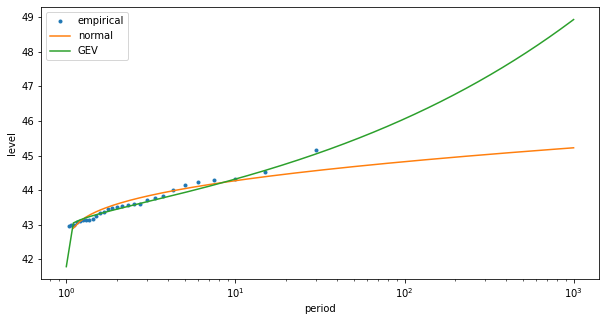

In [182]:
# plot the obs empirical thing and gev
fig, ax = plt.subplots(figsize=(10, 5))

# get empircal values and plot them
_ = empirical_return_level(data.values).plot(ax=ax, marker=".", linestyle="None")

# Create a vector of years
years = np.arange(1, 1000, 0.1)

# calculate and plot the normal return levels
ax.plot(
    years,
    stats.norm.ppf(1 - 1 / years, loc=data.values.mean(), scale=data.values.std()),
)

# calculate and plot the GEV distribution, note the negtive shape parameter
ax.plot(years, gev.ppf(1 - 1 / years, shape, loc=loc, scale=scale))
# set x axis to log scale
ax.set_xscale("log")

# show legend
ax.legend(["empirical", "normal", "GEV"])

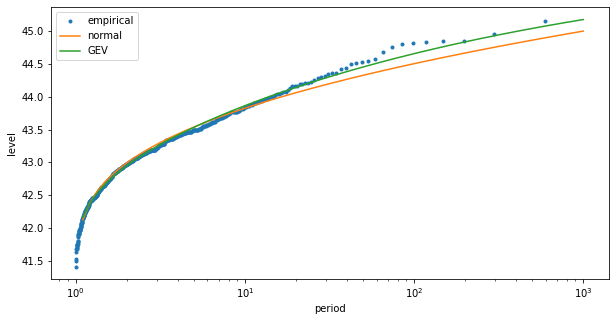

In [183]:
# do the same, but for all of the model data
model_data = model_demand_NDJFM["United_Kingdom_demand"].values

# plot the obs empirical thing and gev
fig, ax = plt.subplots(figsize=(10, 5))

# get empircal values and plot them
_ = empirical_return_level(model_data).plot(ax=ax, marker=".", linestyle="None")

# Create a vector of years
years = np.arange(1, 1000, 0.1)

# calculate and plot the normal return levels
ax.plot(
    years,
    stats.norm.ppf(1 - 1 / years, loc=model_data.mean(), scale=model_data.std()),
)

# calculate and plot the GEV distribution, note the negtive shape parameter
shape, loc, scale = gev.fit(model_data, 0)
ax.plot(years, gev.ppf(1 - 1 / years, shape, loc=loc, scale=scale))

# set x axis to log scale
ax.set_xscale("log")

# show legend
ax.legend(["empirical", "normal", "GEV"])

range of uncertainty for the obs data

100%|██████████| 1000/1000 [00:39<00:00, 25.14it/s]


Mean estimate:  [-0.21108639 43.33853577  0.33590636]  and 95% confidence intervals:  [[-0.74648449 43.1567411   0.21142211]
 [ 0.20369687 43.55403767  0.48541443]]


Text(0, 0.5, 'Return Level (GW)')

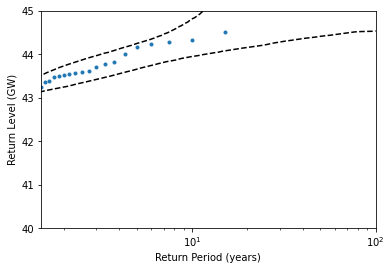

In [144]:
# generate confidence intervals for these plots
params = []

# generate 1000 samples by resampling data with replacement
for i in tqdm(range(1000)):
    params.append(
        gev.fit(np.random.choice(data.values, size=len(data.values), replace=True))
    )

# print the estimate of the mean of each parameter and it's confidence intervals
print(
    "Mean estimate: ",
    np.mean(np.array(params), axis=0),
    " and 95% confidence intervals: ",
    np.quantile(np.array(params), [0.025, 0.975], axis=0),
)

# generate years vector
years = np.arange(1.1, 100, 0.1)

# intialize list for return levels
levels = []

# calculate return levels for each of the 1000 samples
for i in range(1000):
    levels.append(gev.ppf(1 - 1 / years, *params[i]))
levels = np.array(levels)

Text(0, 0.5, 'Return Level (GW)')

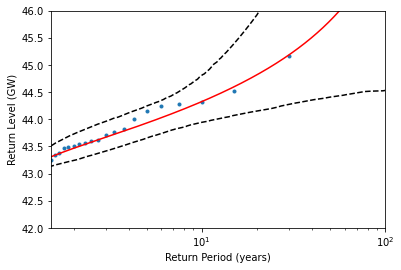

In [147]:
# setup plots
fig, ax = plt.subplots()

# find empirical return levels
_ = empirical_return_level(data.values).plot(ax=ax, marker=".", linestyle="None")

# plot return mean levels
_ = ax.plot(years, levels.mean(axis=0), "r-")

# plot confidence intervals
_ = ax.plot(years, np.quantile(levels, [0.025, 0.975], axis=0).T, "k--")

# shape, loc, scale = gev.fit(data.values, 0)
# ax.plot(years, gev.ppf(1 - 1 / years, shape, loc=loc, scale=scale))

# aesthetics
ax.set_xlim(1.5, 100)
ax.set_ylim(42, 46)
ax.set_xscale("log")
ax.set_xlabel("Return Period (years)")
ax.set_ylabel("Return Level (GW)")


In [151]:
# do the same but for the full model data
# generate confidence intervals for these plots
params = []

# generate 1000 samples by resampling data with replacement
for i in tqdm(range(1000)):
    params.append(
        gev.fit(np.random.choice(model_data, size=len(model_data), replace=True))
    )

# print the estimate of the mean of each parameter and it's confidence intervals
print(
    "Mean estimate: ",
    np.mean(np.array(params), axis=0),
    " and 95% confidence intervals: ",
    np.quantile(np.array(params), [0.025, 0.975], axis=0),
)

# generate years vector
years = np.arange(1.1, 1000, 0.1)

# intialize list for return levels
levels = []

# calculate return levels for each of the 1000 samples
for i in range(1000):
    levels.append(gev.ppf(1 - 1 / years, *params[i]))
levels = np.array(levels)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:46<00:00, 21.59it/s]


Mean estimate:  [ 0.17417723 42.73562921  0.60481831]  and 95% confidence intervals:  [[ 0.1324522  42.68203493  0.57038438]
 [ 0.21626787 42.79096982  0.63872236]]


Text(0, 0.5, 'Return Level (GW)')

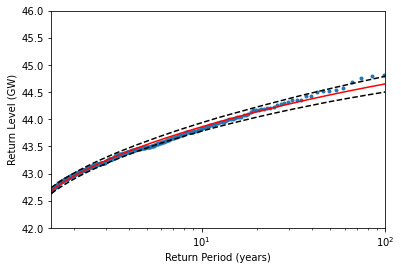

In [154]:
# setup plots
fig, ax = plt.subplots()

# find empirical return levels
_ = empirical_return_level(model_data).plot(ax=ax, marker=".", linestyle="None")

# plot return mean levels
_ = ax.plot(years, levels.mean(axis=0), "r-")

# plot confidence intervals
_ = ax.plot(years, np.quantile(levels, [0.025, 0.975], axis=0).T, "k--")

# shape, loc, scale = gev.fit(data.values, 0)
# ax.plot(years, gev.ppf(1 - 1 / years, shape, loc=loc, scale=scale))

# aesthetics
ax.set_xlim(1.5, 100)
ax.set_ylim(42, 46)
ax.set_xscale("log")
ax.set_xlabel("Return Period (years)")
ax.set_ylabel("Return Level (GW)")

In [180]:
# plot both the observed and model data on the same plot
params_obs = [] ; params_model = []

# generate 1000 samples by resampling data with replacement
for i in tqdm(range(1000)):
    params_obs.append(
        gev.fit(np.random.choice(data.values, size=len(data.values), replace=True))
    )
    params_model.append(
        gev.fit(np.random.choice(model_data, size=len(model_data), replace=True))
    )

# print the estimate of the mean of each parameter and it's confidence intervals
print(
    "Mean estimate obs: ",
    np.mean(np.array(params_obs), axis=0),
    " and 95% confidence intervals: ",
    np.quantile(np.array(params_obs), [0.025, 0.975], axis=0),
)

# print the estimate of the mean of each parameter and it's confidence intervals
print(
    "Mean estimate model: ",
    np.mean(np.array(params_model), axis=0),
    " and 95% confidence intervals: ",
    np.quantile(np.array(params_model), [0.025, 0.975], axis=0),
)

# generate years vector
years = np.arange(1.1, 1000, 0.1)

# intialize list for return levels
levels_obs = [] ; levels_model = []

# calculate return levels for each of the 1000 samples
for i in range(1000):
    levels_obs.append(gev.ppf(1 - 1 / years, *params_obs[i]))
    levels_model.append(gev.ppf(1 - 1 / years, *params_model[i]))
levels_obs = np.array(levels_obs)
levels_model = np.array(levels_model)

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|████▉     | 498/1000 [00:42<00:43, 11.43it/s]/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
100%|██████████| 1000/1000 [01:25<00:00, 11.64it/s]


Mean estimate obs:  [-0.23195125 43.33500727  0.33364876]  and 95% confidence intervals:  [[-0.74172435 43.15264131  0.20200313]
 [ 0.24442795 43.55821935  0.49129679]]
Mean estimate model:  [ 0.17383747 42.7360097   0.60514657]  and 95% confidence intervals:  [[ 0.13246981 42.68029183  0.57116512]
 [ 0.21667472 42.78845551  0.64168049]]


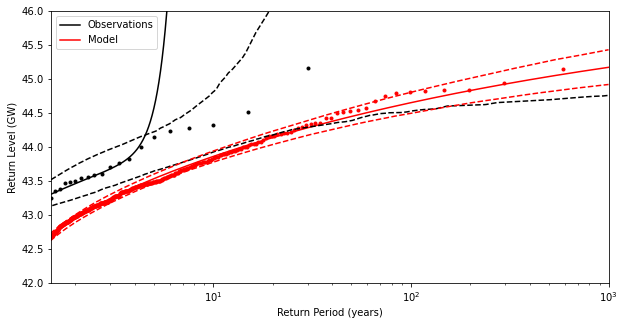

In [181]:
# setup plots
fig, ax = plt.subplots(figsize=(10, 5))

# find empirical return levels
_ = empirical_return_level(data.values).plot(ax=ax, marker=".", linestyle="None", color="k")
_ = empirical_return_level(model_data).plot(ax=ax, marker=".", linestyle="None", color="r")

# plot return mean levels
_ = ax.plot(years, levels_obs.mean(axis=0), "k-", label="Observations")
_ = ax.plot(years, levels_model.mean(axis=0), "r-", label="Model")

# plot confidence intervals
_ = ax.plot(years, np.quantile(levels_obs, [0.025, 0.975], axis=0).T, "k--")
_ = ax.plot(years, np.quantile(levels_model, [0.025, 0.975], axis=0).T, "r--")

# aesthetics
ax.set_xlim(1.5, 1000)
ax.set_ylim(42, 46)
ax.set_xscale("log")
ax.set_xlabel("Return Period (years)")
ax.set_ylabel("Return Level (GW)")

# show legend
ax.legend(loc="upper left")